In [19]:
import numpy as np
import os 
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger


In [20]:

data_dir = '/Users/nopparuj/makima_tsuki/food-101/images'
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)
# print(os.listdir(data_dir))

9000


In [21]:
train_ds = tf.keras.utils.image_dataset_from_directory(data_dir,validation_split=0.2,subset="training",seed=123,image_size=(300,300),batch_size=32)
val_ds = tf.keras.utils.image_dataset_from_directory(data_dir,validation_split=0.2,subset="validation",seed=123,image_size=(300,300),batch_size=32)
class_names = train_ds.class_names
print(class_names)

Found 9000 files belonging to 9 classes.
Using 7200 files for training.
Found 9000 files belonging to 9 classes.
Using 1800 files for validation.
['caesar_salad', 'cheesecake', 'donuts', 'fish_and_chips', 'french_fries', 'fried_rice', 'hamburger', 'pad_thai', 'steak']


In [22]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9862906


In [23]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [24]:
inception = InceptionV3(weights='imagenet', include_top=False)
x = inception.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)

num_classes = 9
predictions = tf.keras.layers.Dense(num_classes,kernel_regularizer=tf.keras.regularizers.l2(0.005), activation='softmax')(x)

model = tf.keras.models.Model(inputs=inception.input, outputs=predictions)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_94 (Conv2D)             (None, None, None,   864         ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization_94 (BatchN  (None, None, None,   96         ['conv2d_94[0][0]']              
 ormalization)                  32)                                                         

In [25]:

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

#If the model tends to overfit / stop!
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs = {}):
        if epoch >= 10 and logs.get("accuracy") is not None and logs.get("val_accuracy") >= 0.1:
            print("Model tends to be overfitting.Stop it.")
            self.model.stop_training = True
        elif logs.get('acccuracy') is not None and logs.get('accuracy') > 0.95:
            print("Model tends to be overfitting.Stop it.")
            self.model.stop_training = True
callback = myCallback()

In [27]:

checkpointer = ModelCheckpoint(filepath='/Users/nopparuj/food_for_thoughts/9C_model/best_model_9class.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history_9class.log')

history = model.fit(train_ds,epochs = 30,batch_size = 32,validation_data = val_ds,
                   callbacks = [callback,],verbose = 1)

model.save('/Users/nopparuj/food_for_thoughts/9C_model/9class.hdf5')



Epoch 1/30
225/225 [==============================] - ETA: 0s - loss: 1.8958 - accuracy: 0.4204

2022-11-13 14:47:13.258304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


225/225 [==============================] - 459s 2s/step - loss: 1.8958 - accuracy: 0.4204 - val_loss: 1.5527 - val_accuracy: 0.6589
Epoch 2/30
225/225 [==============================] - 383s 2s/step - loss: 1.3025 - accuracy: 0.6969 - val_loss: 1.0901 - val_accuracy: 0.7778
Epoch 3/30
225/225 [==============================] - 448s 2s/step - loss: 0.9225 - accuracy: 0.7953 - val_loss: 0.8228 - val_accuracy: 0.8300
Epoch 4/30
225/225 [==============================] - 470s 2s/step - loss: 0.7069 - accuracy: 0.8435 - val_loss: 0.6785 - val_accuracy: 0.8556
Epoch 5/30
225/225 [==============================] - 517s 2s/step - loss: 0.5727 - accuracy: 0.8772 - val_loss: 0.5963 - val_accuracy: 0.8678
Epoch 6/30
225/225 [==============================] - 527s 2s/step - loss: 0.4800 - accuracy: 0.9017 - val_loss: 0.5461 - val_accuracy: 0.8733
Epoch 7/30
225/225 [==============================] - 578s 3s/step - loss: 0.4111 - accuracy: 0.9228 - val_loss: 0.5124 - val_accuracy: 0.8794
Epoch 8/30

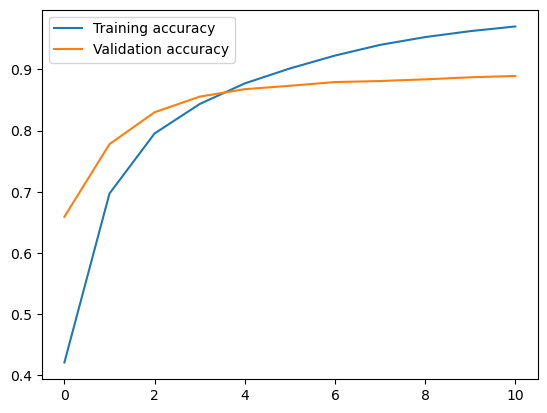

In [28]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(11)
plt.plot(epochs,acc,label = "Training accuracy")
plt.plot(epochs,val_acc,label = "Validation accuracy")
plt.legend()
plt.show()

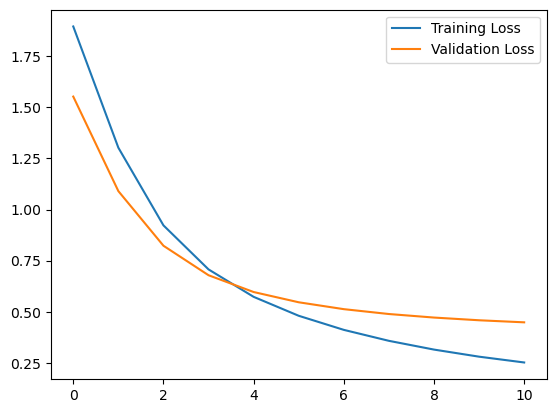

In [29]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.plot(epochs,loss,label = "Training Loss")
plt.plot(epochs,val_loss,label = "Validation Loss")
plt.legend()
plt.show()

In [30]:
# For validation purpose, please run only these cells below, unless remodeling is required.

In [31]:
print('0-caesar_salad', '1-cheesecake', '2-donuts', '3-fish_and_chips', '4-french_fries', '5-fried_rice', '6-hamburger', '7-pad_thai', '8-steak')

0-caesar_salad 1-cheesecake 2-donuts 3-fish_and_chips 4-french_fries 5-fried_rice 6-hamburger 7-pad_thai 8-steak


In [32]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = probability_model.predict(val_ds)

#Manual checking
i = 3
predictions[i]
print(np.argmax(predictions[i]))


2022-11-13 16:14:42.833089: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


57/57 [==============================] - 47s 795ms/step
2


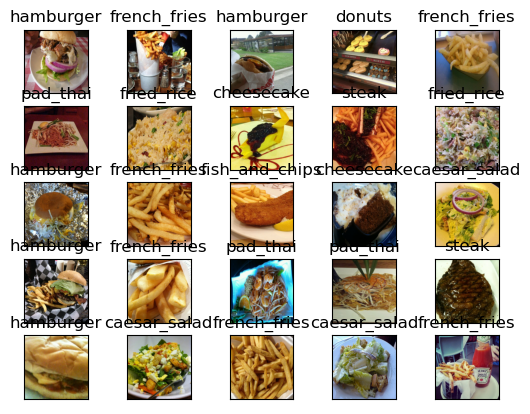

In [33]:
#Use this to check from validation data
plt.figure(1)
for images, labels in val_ds.take(1):
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(images[i].numpy().astype(np.uint8))
        plt.title(class_names[labels[i]])
plt.show()